## Prediction Issue

<class 'numpy.ndarray'>
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


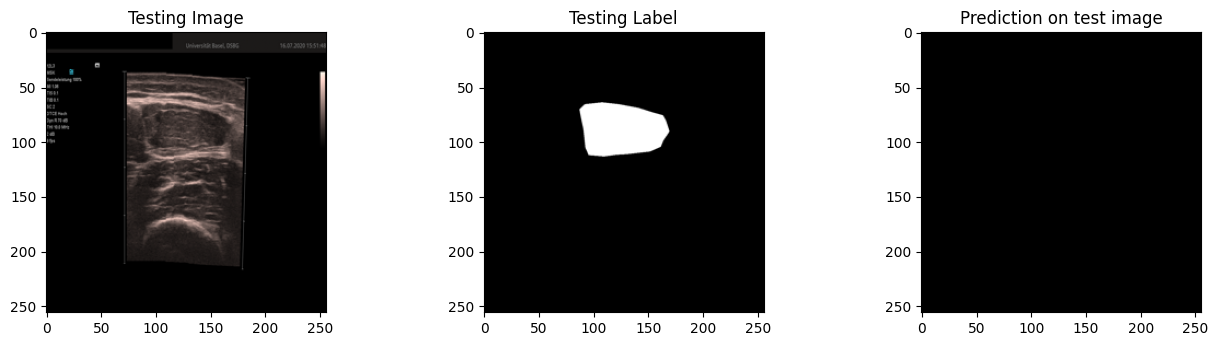

In [23]:
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
from PIL import Image
from keras.models import load_model
from keras_unet_collection.transformer_layers import patch_extract, patch_embedding, SwinTransformerBlock, patch_merging, patch_expanding
from keras import backend as K
#######################################################

image_directory = 'D:/UniBas/Bachelorarbeit/some_images/'
mask_directory = 'D:/UniBas/Bachelorarbeit/some_masks/'


SIZE = 256
image_dataset = []  
mask_dataset = []  

images = os.listdir(image_directory)
for i, image_name in enumerate(images):    
    if (image_name.split('.')[1] == 'tif'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))


masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))


#Normalize images
image_dataset = np.array(image_dataset)/255.
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

#######################################################

def IoU(y_true, y_pred, smooth=1):
    """Computes intersection over union (IoU), a measure of labelling accuracy.

    Arguments:
        The ground-truth bit-mask,
        The predicted bit-mask,
        A smoothing parameter,

    Returns:
        Intersection over union scores.

    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

model1 = load_model("D:/UniBas/Bachelorarbeit/ComparisonA/Task A/Results_Swin/A_modelSwinV1.h5", 
                   custom_objects={'IoU': IoU, 
                            "patch_extract": patch_extract, #requirement of Swin and Trans
                            "patch_embedding": patch_embedding, #requirement of Swin and Trans
                            "SwinTransformerBlock": SwinTransformerBlock, #requirement of Swin
                            "patch_merging": patch_merging, #requirement of Swin
                            "patch_expanding": patch_expanding, #requirement of Swin
                   })

model2 = load_model("D:/UniBas/Bachelorarbeit/ComparisonA/Task A/Results_Vgg/A_modelVGG16V1.h5", 
                   custom_objects={'IoU': IoU, 
                            "patch_extract": patch_extract, #requirement of Swin and Trans
                            "patch_embedding": patch_embedding, #requirement of Swin and Trans
                            "SwinTransformerBlock": SwinTransformerBlock, #requirement of Swin
                            "patch_merging": patch_merging, #requirement of Swin
                            "patch_expanding": patch_expanding, #requirement of Swin
                   })
#model2 = load_model("D:/UniBas/Bachelorarbeit/ComparisonA/Task A/Results_Vgg/A_modelVGG16V1.h5")

import random
test_img_number = random.randint(0, X_test.shape[0]-1)
    

test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model1.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

print((type(prediction)))
print((prediction))


plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()
